# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from time import time
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an 
, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an \n, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# upzip files
with ZipFile('support materials/CSV data files.zip','r') as zips:
    zips.printdir()
    zips.extractall()

File Name                                             Modified             Size
AZDIAS_Feature_Summary.csv                     2020-05-05 16:23:54         3156
Udacity_AZDIAS_Subset.csv                      2020-05-05 16:24:40    157145280
Udacity_CUSTOMERS_Subset.csv                   2020-05-05 16:24:16     32338227


In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [7]:
azdias.query('GEBURTSJAHR == 0')['GEBURTSJAHR']

0         0
6         0
11        0
12        0
14        0
         ..
891209    0
891210    0
891212    0
891215    0
891220    0
Name: GEBURTSJAHR, Length: 392318, dtype: int64

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# data is naturally missing
naturally_missing=azdias.isna().sum().sum()
print('data is naturally missing:',naturally_missing)

data is naturally missing: 4896838


- Identify missing or unknown data values and convert them to NaNs.

In [10]:
# format missing_or_unknown
misslist= feat_info['missing_or_unknown'].apply(lambda x: x.replace('[','').replace(']','').split(','))

In [11]:
# map column name to missing_or_unknown as dict
attribute_nan= {}
for key ,item in zip(feat_info['attribute'],misslist):
    attribute_nan[key]=item

In [12]:
# replace values with np.nan
for column in list(azdias):
    for value in attribute_nan[column]:
        if value == '':
            pass
        elif azdias[column].dtype == 'int64':
            azdias[column].replace(int(value),np.nan, inplace=True)
        elif azdias[column].dtype == 'float64':
            azdias[column].replace(float(value),np.nan,inplace=True)
        elif azdias[column].dtype == 'object':
            azdias[column].replace(str(value),np.nan,inplace=True)

In [13]:
azdias.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
644083,NaN,2.0,1,4.0,4,4,2,4,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347296,NaN,3.0,2,5.0,2,2,3,3,1,4,...,1.0,4.0,2.0,2.0,4.0,3.0,2.0,4.0,9.0,3.0
865902,NaN,3.0,1,5.0,5,2,4,3,2,1,...,3.0,3.0,2.0,1.0,1.0,3.0,3.0,NaN,NaN,NaN
9622,NaN,4.0,1,1.0,3,1,4,1,1,5,...,1.0,3.0,3.0,2.0,5.0,3.0,2.0,4.0,9.0,3.0
775738,NaN,1.0,1,3.0,2,4,1,2,3,4,...,2.0,4.0,2.0,1.0,5.0,2.0,2.0,4.0,8.0,4.0


In [14]:
# data takes on a 'missing' or 'unknown' code
mon=azdias.isna().sum().sum()-naturally_missing
print("data takes on a 'missing' or 'unknown' code:",mon)

data takes on a 'missing' or 'unknown' code: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_nan= azdias.isna().sum()
col_nan

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

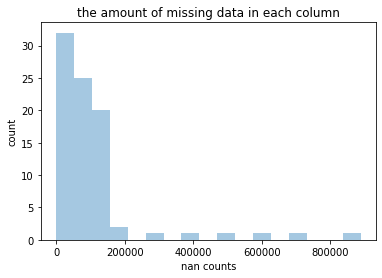

In [16]:
# Investigate patterns in the amount of missing data in each column.

sns.distplot(col_nan.values, kde=False)
plt.ylabel('count')
plt.xlabel('nan counts')
plt.title('the amount of missing data in each column');

> columns with over 200000 nan values will be considered as outliers according to the plot

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drops=col_nan[col_nan.values > 200000].index
azdias.drop(drops, axis = 1,inplace = True)

In [18]:
drops

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [19]:
azdias.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
209780,3.0,2,5.0,1,5,2,4,5,5,1,...,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,7.0,5.0
352328,2.0,1,4.0,2,4,1,3,5,3,4,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,2.0,5.0,2.0
735762,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454711,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181962,2.0,1,3.0,3,3,4,2,2,3,6,...,1.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,9.0,3.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The plot indicats majority of columns contains number NaNs under 200000, which left 6 columns become outliers due to the fact there are too many missing values. They are:

- Best-ager typology
- Year of birth
- Academic title flag
- Birthdate of head of household
- Consumer pattern over past 12 months
- Most common building type within the microcell

One patterns we can see is those columns contain information either personal or subjective. This might because people were not comfortable to share certain level of personal info as well as household info. As subjective question people might or might not have strong opinions on all of the choices they were presented. It is the best practice to drop those columns to omit potential effects on further analysis.

In [20]:
# columns dropped
feat_info[feat_info['attribute'].isin(drops)]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
rowmiss=azdias.isna().sum(axis=1)
rowmiss

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

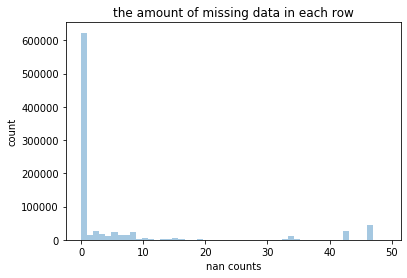

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
sns.distplot(rowmiss.values,kde=False)
plt.title('the amount of missing data in each row')
plt.ylabel('count')
plt.xlabel('nan counts');

> rows with over 20 nan values will be considered as outliers according to the plot

In [23]:
# records with more than 20 nans
azdias_m=azdias.iloc[rowmiss[rowmiss.values>20].index,:]
# records with less or  than 20 nans
azdias_l=azdias.iloc[rowmiss[rowmiss.values<=20].index,:]

In [24]:
azdias_l.shape

(797426, 79)

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def com():
    for i in comparelist:
        plt.figure(figsize=(20,5))
        plt.subplot(121)
        sns.countplot(azdias_l[i],color='c',alpha=.5)
        plt.title('set with less NaN')
        plt.subplot(122)
        sns.countplot(azdias_m[i], color='y',alpha=.5)
        plt.title('set with more NaN');

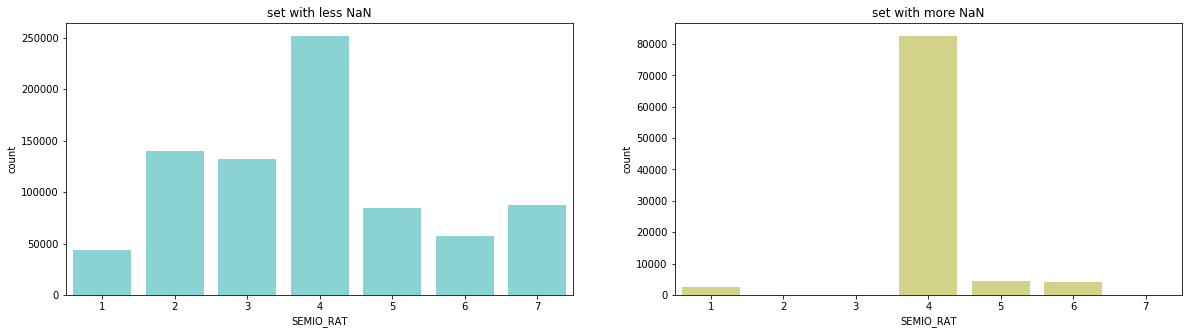

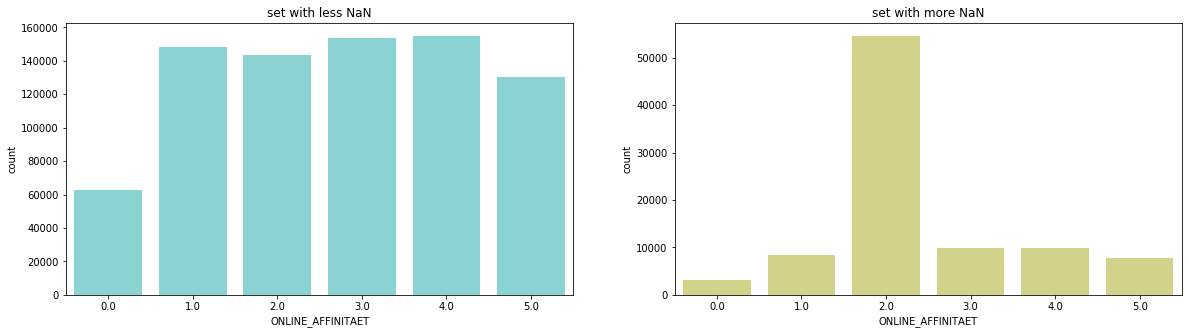

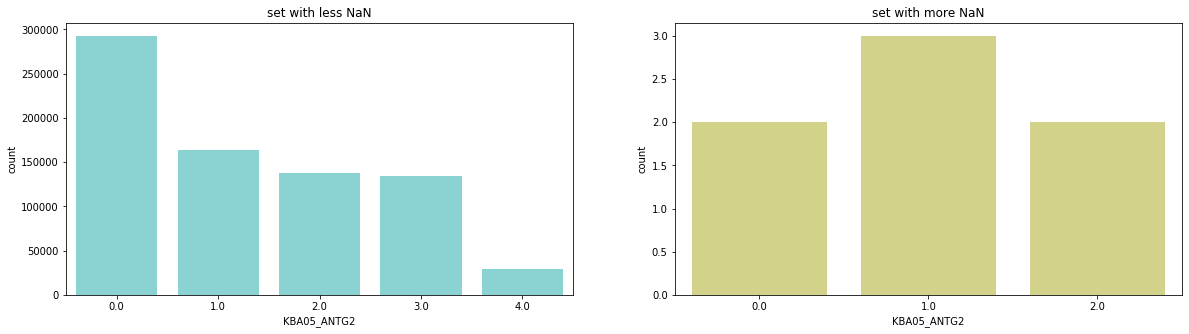

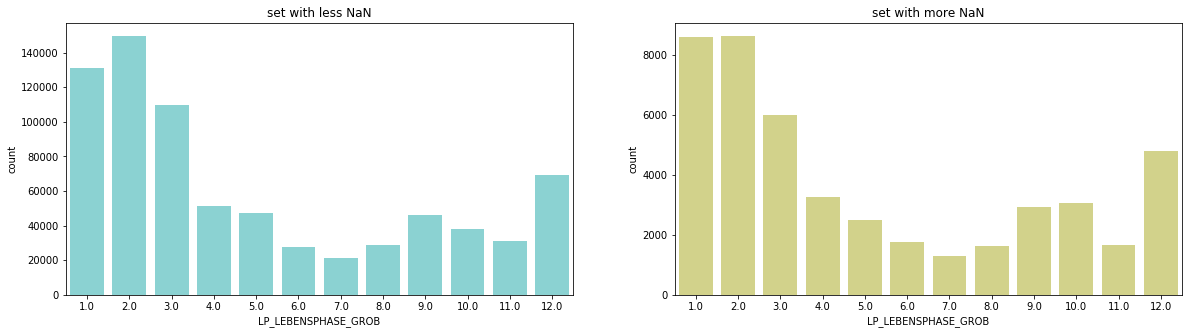

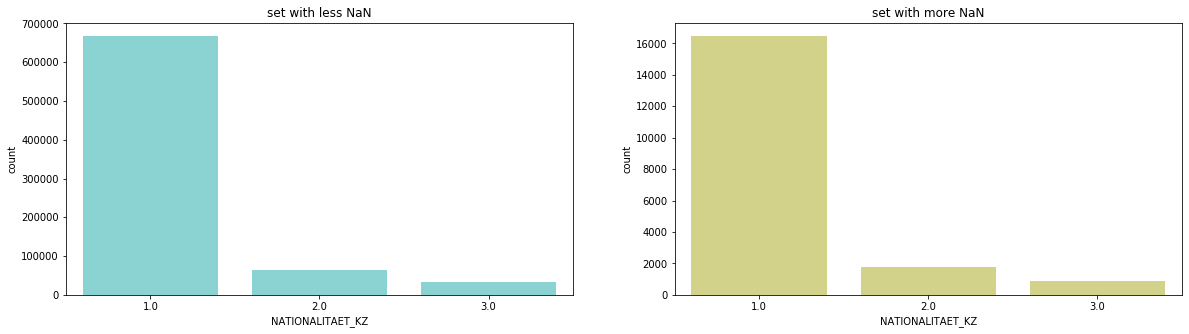

In [26]:
comparelist=[azdias.columns[i] for i in np.random.randint(0,79,5)]
com()

#### Discussion 1.1.3: Assess Missing Data in Each Row

From NaN values distribution I set a threshold at 20, those ones have more than 20 features with NaN values we would consider an separate subset. It also looks like majority of NaN values cluster at last 30 columns. As for two subsets data distribustion, we are able to see obvious differences between some features. This suggests further investigation is needed.

In [27]:
azdias_m.iloc[:,-25:].sample(5)

,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
150395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
# feat_info without outlier columns
feat_info_clean=feat_info[feat_info['attribute'].isin(list(azdias_l))]

In [29]:
feat_info_clean['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
feat_info_clean

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# pick out columns are categorical
catcol=feat_info_clean.query("type == 'categorical'")['attribute'].values
azdias_l[catcol]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,2,5.0,1,12.0,0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,4,8.0,W,7,7A
891217,1,4.0,6,1.0,0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,NaN,6,8.0,W,9,9D
891218,2,4.0,1,10.0,0,NaN,NaN,4.0,2.0,1.0,2.0,0.0,1.0,4,8.0,W,4,4C
891219,1,3.0,1,9.0,0,9.0,5.0,2.0,1.0,1.0,0.0,0.0,2.0,5,8.0,W,9,9D


In [32]:
azdias_l[catcol].describe().loc['max',:]

ANREDE_KZ            2.0
CJT_GESAMTTYP        6.0
FINANZTYP            6.0
GFK_URLAUBERTYP     12.0
GREEN_AVANTGARDE     1.0
LP_FAMILIE_FEIN     11.0
LP_FAMILIE_GROB      5.0
LP_STATUS_FEIN      10.0
LP_STATUS_GROB       5.0
NATIONALITAET_KZ     3.0
SHOPPER_TYP          3.0
SOHO_KZ              1.0
VERS_TYP             2.0
ZABEOTYP             6.0
GEBAEUDETYP          8.0
Name: max, dtype: float64

> there are three columns contain binary values:
- GREEN_AVANTGARDE
- SOHO_KZ
- OST_WEST_KZ (non-numeric)


>  <font color='red'>**ATTENTION**</font> : During the first attempt customers_clean df shape is different than what we expected. Demographics set has 195 features before PCA while customers_clean has 194. After sanity check I found out there is one record in azdias_l df has an attribute ``'GEBAEUDETYP'==5.0``, this results a new dummy column ``['GEBAEUDETYP_5.0']``. It is the best practice to drop this feature since customers dataset won't match up. Following processes have been adjusted accordingly.
<img src="support materials/GEBAEUDETYP_error.png" width=500px>

In [33]:
# update catcol list not include 'GREEN_AVANTGARDE' and 'SOHO_KZ' and'GEBAEUDETYP'
catcol= [i for i in catcol if i != 'GREEN_AVANTGARDE' and i!= 'SOHO_KZ' and i!= 'GEBAEUDETYP']
catcol

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_l=pd.get_dummies(data= azdias_l, columns=catcol)
azdias_l.sample(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
412990,4.0,5,2,4,2,2,1,1,2.0,39.0,...,0,0,0,0,0,0,0,0,0,0
415467,4.0,4,2,5,1,1,5,1,1.0,8.0,...,0,0,0,0,0,0,0,0,1,0
642468,3.0,3,5,3,5,4,2,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
487904,4.0,3,2,5,1,1,5,0,2.0,31.0,...,0,0,0,1,0,0,0,0,0,0
795173,1.0,1,5,3,5,4,5,0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

There are categorical 18 columns and three of them contain binary values:
- GREEN_AVANTGARDE
- SOHO_KZ
- OST_WEST_KZ (non-numeric)

I decided to onehot encoding them all and keep them (except ``GEBAEUDETYP`` as reason was stated above) for now beacuse there is not enough insight to tell which one provide more info or less. They will be combined through PCA process later. The new dataframe has 191 features for now.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
mix=feat_info_clean.query("type == 'mixed'")['attribute'].values
mix

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

In [36]:
azdias_l.loc[:,mix]

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0
...,...,...,...,...,...,...
891216,2.0,1.0,14.0,3.0,41,1.0
891217,2.0,1.0,10.0,5.0,51,4.0
891218,NaN,NaN,14.0,7.0,24,1.0
891219,29.0,9.0,14.0,5.0,51,5.0


In [37]:
azdias_l['PRAEGENDE_JUGENDJAHRE']

1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
          ... 
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 797426, dtype: float64

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# create dicts
avantgarde=[2,4,6,7,9,11,13,15]
mainstream=[1,3,5,8,10,12,14]

decade={1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

movement={i: 0 for i in avantgarde}
for y in mainstream:
    movement[y]=1
movement

{2: 0,
 4: 0,
 6: 0,
 7: 0,
 9: 0,
 11: 0,
 13: 0,
 15: 0,
 1: 1,
 3: 1,
 5: 1,
 8: 1,
 10: 1,
 12: 1,
 14: 1}

In [39]:
# PRAEGENDE_JUGENDJAHRE_decade column
azdias_l['PRAEGENDE_JUGENDJAHRE_decade']=azdias_l['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decade[x] if x==x else x)

In [40]:
# PRAEGENDE_JUGENDJAHRE_movement column
azdias_l['PRAEGENDE_JUGENDJAHRE_movement']=azdias_l['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: movement[x] if x ==x else x)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_l['CAMEO_INTL_2015_wealth'],azdias_l['CAMEO_INTL_2015_stage'] =azdias_l['CAMEO_INTL_2015'].str[0],azdias_l['CAMEO_INTL_2015'].str[1]

In [42]:
# drop extra features
azdias_l.drop(mix,axis=1, inplace=True)
azdias_l.sample(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_stage
521959,3.0,3,4,2,1,5,3,1,NaN,1.0,...,0,0,0,0,0,0,90.0,0.0,4,3
401059,4.0,4,1,5,1,1,4,0,2.0,5.0,...,0,0,0,0,0,0,50.0,1.0,4,4
277394,3.0,2,2,4,2,3,4,0,3.0,5.0,...,0,0,1,0,0,0,80.0,1.0,5,1
204547,1.0,1,4,1,4,3,5,0,3.0,1.0,...,0,0,0,0,0,0,90.0,1.0,3,5
726683,2.0,3,4,1,5,2,2,0,2.0,4.0,...,0,0,0,0,0,0,80.0,1.0,4,1


#### Discussion 1.2.2: Engineer Mixed-Type Features

There were six Mixed-Type Features, they were:
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- PRAEGENDE_JUGENDJAHRE
- WOHNLAGE
- CAMEO_INTL_2015
- PLZ8_BAUMAX

For LP_LEBENSPHASE_FEIN I created two dictionaries to map correspond keys to the interval-type or binary values we desired. I then change binary data type to int64.
For PRAEGENDE_JUGENDJAHRE I used string split to split tens'-place and 'ones'-place then created two columns with those.
For simplicity, i decided to drop other Mixed-Type Features as well as original two features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_l.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 189 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            794642 non-null  float64
 1   FINANZ_MINIMALIST               797426 non-null  int64  
 2   FINANZ_SPARER                   797426 non-null  int64  
 3   FINANZ_VORSORGER                797426 non-null  int64  
 4   FINANZ_ANLEGER                  797426 non-null  int64  
 5   FINANZ_UNAUFFAELLIGER           797426 non-null  int64  
 6   FINANZ_HAUSBAUER                797426 non-null  int64  
 7   GREEN_AVANTGARDE                797426 non-null  int64  
 8   HEALTH_TYP                      761009 non-null  float64
 9   RETOURTYP_BK_S                  792792 non-null  float64
 10  SEMIO_SOZ                       797426 non-null  int64  
 11  SEMIO_FAM                       797426 non-null  int64  
 12  SEMIO_REL      

In [44]:
# change data type
changelist=['CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_stage']
for i in changelist:
    azdias_l[i]=azdias_l[i].astype(float)

In [45]:
azdias_l.shape

(797426, 189)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # format missing_or_unknown
    misslist= feat_info['missing_or_unknown'].apply(lambda x: x.replace('[','').replace(']','').split(','))
    # map column name to missing_or_unknown as dict
    attribute_nan= {}
    for key ,item in zip(feat_info['attribute'],misslist):
        attribute_nan[key]=item
    # replace values with np.nan
    for column in list(df):
        for value in attribute_nan[column]:
            if value == '':
                pass
            elif df[column].dtype == 'int64':
                df[column].replace(int(value),np.nan, inplace=True)
            elif df[column].dtype == 'float64':
                df[column].replace(float(value),np.nan,inplace=True)
            elif df[column].dtype == 'object':
                df[column].replace(str(value),np.nan,inplace=True)
                
                
    # remove selected columns and rows, ...
    #col_nan= df.isna().sum()
    # Remove the outlier columns from the dataset.
    #drops=col_nan[col_nan.values > 200000].index
    #df.drop(drops, axis = 1,inplace = True)
    
    
    '''customer dataset nan volume will be different than demographic dataset, instead of using 200000 as threshold
        we need to drop the same columns as we did to azdias df for consistency.'''
    
    
    
    #print('~~~~~~~~~~~',azdias.columns)
    df=df[azdias.columns]
    print('~~~~~~~~~~~~~~~',df.shape)
    
    # we want all the customer records therefor there will be no rows assessing 
    # assessing rows
    #rowmiss=df.isna().sum(axis=1)
    # records with more than 20 nans
    #df_m=df.iloc[rowmiss[rowmiss.values>20].index,:]
    # records with less or equal to 20 nans
    #df_l=df.iloc[rowmiss[rowmiss.values<=20].index,:]
    
    #print('~~~~~~~~~~~~~~~',df_l.shape)
    
    # select, re-encode, and engineer column values.
    # feat_info without outlier columns
    feat_info_clean=feat_info[feat_info['attribute'].isin(list(df))]
    # pick out columns are categorical
    catcol=feat_info_clean.query("type == 'categorical'")['attribute'].values
    #print(catcol)
    # update catcol list not include 'GREEN_AVANTGARDE' and 'SOHO_KZ'
    catcol= [i for i in catcol if i != 'GREEN_AVANTGARDE' and i!= 'SOHO_KZ' and i!= 'GEBAEUDETYP']
    
   
    # Re-encode categorical variable(s) to be kept in the analysis.
    #print('~~~~~~~~~~',df.shape)
    df=pd.get_dummies(data= df, columns=catcol)
    #print('~~~~~~~~~~',df.shape)
    # mixed type variables
    mix=feat_info_clean.query("type == 'mixed'")['attribute'].values
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # create dicts
    avantgarde=[2,4,6,7,9,11,13,15]
    mainstream=[1,3,5,8,10,12,14]

    decade={1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

    movement={i: 0 for i in avantgarde}
    for y in mainstream:
        movement[y]=1
    # PRAEGENDE_JUGENDJAHRE_decade column
    df['PRAEGENDE_JUGENDJAHRE_decade']=df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decade[x] if x==x else x)
    # PRAEGENDE_JUGENDJAHRE_movement column
    df['PRAEGENDE_JUGENDJAHRE_movement']=df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: movement[x] if x ==x else x)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['CAMEO_INTL_2015_wealth'],df['CAMEO_INTL_2015_stage'] =df['CAMEO_INTL_2015'].str[0],df['CAMEO_INTL_2015'].str[1]
    # drop extra features
    df.drop(mix,axis=1, inplace=True)
    # change data type
    changelist=['CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_stage']
    for i in changelist:
        df[i]=df[i].astype(float)
    
    
    # Return the cleaned dataframe.
    return df
    

>  <font color='red'>**ATTENTION**</font>: customer dataset nan volume will be different than demographic dataset, instead of using 200000 as threshold
        we need to drop the same columns as we did to azdias df for consistency.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [119]:
copydf=azdias_l.copy()

In [120]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('total nan remain:',copydf.isna().sum().sum(), ',total rows number with nan :',len(copydf[copydf.isna().any(axis=1)].index))

total nan remain: 715462 ,total rows number with nan : 174215


In [121]:
# make a copy to temporarily remove nans
copydf_nonan=copydf.copy()
copydf_nonan.dropna(axis=0,inplace=True)
copydf_nonan.isna().sum().sum()

0

In [122]:
# df shape after remove nans 
copydf_nonan.shape

(623211, 189)

In [123]:
# get scaling parameters without missing values
scaler= StandardScaler()
scaler.fit(copydf_nonan)
mean=scaler.mean_
scale=scaler.scale_
var=scaler.var_

In [124]:
# impute nan values
imp=SimpleImputer().fit(copydf)
copydf_impute= imp.transform(copydf)

In [125]:
copydf_impute.shape

(797426, 189)

In [126]:
# StandardScaler with parameters
scaler_impute= StandardScaler()
scaler_impute.mean_=mean
scaler_impute.scale_=scale
scaler_impute.var_=var
scaleimpute_copy=scaler_impute.transform(copydf_impute)
scaleimpute_copy

array([[-1.74628678, -1.51222588,  1.58106079, ...,  0.55367151,
         1.14788447, -1.25111082],
       [ 0.202108  , -1.51222588,  0.90044628, ..., -1.80612507,
        -0.90999235,  0.74981994],
       [ 1.17630539,  0.6924003 , -0.46078275, ...,  0.55367151,
        -1.59595129, -0.5841339 ],
       ...,
       [-0.77208939, -0.77735049,  0.90044628, ...,  0.55367151,
        -0.90999235,  0.74981994],
       [-1.74628678, -1.51222588,  1.58106079, ...,  0.55367151,
         1.14788447, -1.25111082],
       [ 1.17630539,  0.6924003 , -0.46078275, ...,  0.55367151,
         0.46192553,  0.08284302]])

### Discussion 2.1: Apply Feature Scaling

After wrangling total nan remain: 715462 ,total rows number with nan : 174215. I decided to keep rows with NaNs due to high volume fact, they could have impact on clustering result. Handling processing as follow:
1. filter out records without missing values
2. get StandardScaler parameters on 'perfect' records
3. impute missing value with means in original set
4. scale the original set with parameters we got in setp 2

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [128]:
scaleimpute_copy.shape

(797426, 189)

In [129]:
# Apply PCA to the data.
pca= PCA()
pca.fit(scaleimpute_copy)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [130]:
# Investigate the variance accounted for by each principal component.
ratios=pca.explained_variance_ratio_
print(ratios)

[7.83047518e-02 5.77464763e-02 3.90179785e-02 2.75837298e-02
 2.51853649e-02 2.02157588e-02 1.53446303e-02 1.48374338e-02
 1.30959455e-02 1.30070395e-02 1.26959922e-02 1.22649386e-02
 1.19916786e-02 1.16732463e-02 1.14128654e-02 1.12974594e-02
 1.12156830e-02 1.09807755e-02 1.08035737e-02 1.06145413e-02
 1.04870915e-02 1.02886136e-02 9.90282690e-03 9.37227797e-03
 9.30811840e-03 9.16081407e-03 8.83053747e-03 8.41803333e-03
 8.35164939e-03 7.88285981e-03 7.67181697e-03 7.34703228e-03
 7.29502565e-03 7.16498712e-03 6.98597452e-03 6.85801322e-03
 6.74951171e-03 6.63585637e-03 6.54727363e-03 6.41301593e-03
 6.38816585e-03 6.27779093e-03 6.20891304e-03 6.17039327e-03
 6.12464058e-03 5.96666091e-03 5.90778991e-03 5.85380027e-03
 5.80756845e-03 5.77017745e-03 5.69452475e-03 5.67372470e-03
 5.61579764e-03 5.59536140e-03 5.53845570e-03 5.50892314e-03
 5.46667121e-03 5.39359367e-03 5.38577901e-03 5.34267142e-03
 5.32038583e-03 5.31623420e-03 5.28474307e-03 5.26247808e-03
 5.23568316e-03 5.210632

In [131]:
# cumulative variability
cumulative=[]
result=0
for i in ratios:
    result+=i
    cumulative.append(result)

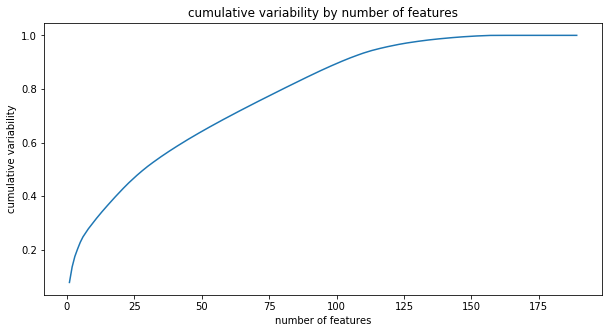

In [132]:
# plot
plt.figure(figsize=(10,5))
sns.lineplot(np.arange(len(ratios))+1,cumulative)
plt.title('cumulative variability by number of features')
plt.xlabel('number of features')
plt.ylabel('cumulative variability');

In [133]:
# function to find number of feature can explain over 85% variability
def pcatry(arange):
    time0=time()
    #cumulative=[]
    #trylist=[]
    step=0
    for i in arange:
        #trylist.append(i)
        step+=1
        pca= PCA(n_components= i).fit(scaleimpute_copy)
        result = pca.explained_variance_ratio_.sum()
        #cumulative.append(result)
        if result>=.85:
            print('cumulative variability:{:.3f}, number of features: {}, duration {:.3f}'.format(result,i,time()-time0))
            #print(trylist,cumulative)
            #sns.lineplot(trylist,cumulative)
            break
        elif step == len(arange):
            print('not found, duration {:.3f}'.format(time()-time0))

In [134]:
# execute function
arange=np.arange(90,97,1)
pcatry(arange)

cumulative variability:0.851, number of features: 91, duration 47.560


In [161]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca92= PCA(n_components=92).fit(scaleimpute_copy)
pca_copydf=pca92.transform(scaleimpute_copy)

In [136]:
pca_copydf.shape

(797426, 92)

### Discussion 2.2: Perform Dimensionality Reduction

From the plot we cal tell when feature number reach around 125, the cumulative variability growth trend starts to become smooth. It indicates redundant features. Therefor I set the threshold at 85%, which needs 92 features.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [137]:
# reshape pca92.components_ for dataframe transformation
reshapepca92=pca92.components_.reshape(pca92.components_.shape[1],pca92.components_.shape[0])

In [138]:
reshapepca92.shape

(189, 92)

In [139]:
# transfrom to df
pcamapdf=pd.DataFrame(reshapepca92, index= copydf.columns,columns=['PC-'+str(i) for i in np.arange(1,93)])
pcamapdf

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-83,PC-84,PC-85,PC-86,PC-87,PC-88,PC-89,PC-90,PC-91,PC-92
ALTERSKATEGORIE_GROB,-0.076435,-0.192953,0.109464,-0.075535,0.051497,0.043494,0.162215,-0.100315,0.023594,-0.005772,...,0.024554,0.058084,0.087992,-0.029056,0.005020,0.004615,-0.001630,-0.008172,-0.020216,-0.028786
FINANZ_MINIMALIST,-0.003963,-0.041045,-0.045048,0.087992,-0.029056,0.004019,-0.035830,-0.062522,0.125405,0.119331,...,0.012291,0.002570,0.062160,0.040571,0.033526,0.025755,0.038381,0.055369,0.056337,0.056742
FINANZ_SPARER,0.021132,0.063854,0.097521,0.188106,-0.106710,0.230190,0.094270,-0.231896,0.219060,-0.204631,...,0.020960,0.044707,0.022086,-0.075138,0.008895,-0.015540,-0.042718,0.053517,0.035375,-0.025389
FINANZ_VORSORGER,-0.029996,-0.024543,-0.040286,-0.047407,-0.037757,-0.009262,-0.018528,-0.028916,0.053517,0.035375,...,0.022548,0.011137,-0.005184,0.005799,0.011675,0.010583,0.011714,0.012025,0.006775,0.014077
FINANZ_ANLEGER,0.031529,-0.007136,-0.000288,0.003235,0.009236,0.045402,-0.235499,0.000345,0.048633,0.018496,...,0.003581,-0.020519,0.001084,0.025797,0.009683,0.008183,0.003278,0.007487,-0.030661,0.002805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMEO_DEU_2015_9E,0.021545,0.015133,0.001433,-0.003592,-0.008664,-0.015836,0.021916,0.001433,0.005417,0.068887,...,0.022886,-0.009104,0.012606,-0.027726,-0.007436,0.011947,-0.005499,-0.018812,-0.030680,-0.015451
PRAEGENDE_JUGENDJAHRE_decade,-0.034082,-0.013798,-0.028471,-0.074866,-0.004483,-0.019193,0.007985,-0.039464,-0.048082,-0.018380,...,0.124160,0.042325,-0.104859,0.006953,0.005927,-0.013772,-0.018318,0.010665,0.056449,-0.056280
PRAEGENDE_JUGENDJAHRE_movement,0.054656,-0.010909,-0.044298,0.087077,-0.155566,-0.017232,-0.008423,-0.016073,0.013138,0.013032,...,-0.182687,0.022445,0.021907,-0.039742,-0.015801,-0.009156,0.004345,0.017220,-0.023803,0.007151
CAMEO_INTL_2015_wealth,0.033764,-0.046496,0.007786,-0.003532,0.029045,-0.023137,0.011810,0.041119,0.022095,-0.021424,...,-0.117508,0.156425,-0.034639,-0.000068,0.043575,-0.095162,-0.008983,0.065481,-0.013606,0.002387


In [140]:
# convert to dict
pcadict=pcamapdf.to_dict()
pcadict

{'PC-1': {'ALTERSKATEGORIE_GROB': -0.07643513602937625,
  'FINANZ_MINIMALIST': -0.0039631915588750725,
  'FINANZ_SPARER': 0.02113167569602416,
  'FINANZ_VORSORGER': -0.029996193533676472,
  'FINANZ_ANLEGER': 0.03152864857761778,
  'FINANZ_UNAUFFAELLIGER': -0.0017483429400068971,
  'FINANZ_HAUSBAUER': 0.002168943657520136,
  'GREEN_AVANTGARDE': 0.006920437148614776,
  'HEALTH_TYP': 0.005590232358923656,
  'RETOURTYP_BK_S': -0.03401278486532183,
  'SEMIO_SOZ': -0.00037761975905687984,
  'SEMIO_FAM': -0.0354804616506263,
  'SEMIO_REL': -0.03704297196114404,
  'SEMIO_MAT': -0.024352749970905724,
  'SEMIO_VERT': -0.11491617943853846,
  'SEMIO_LUST': -0.05585188194409952,
  'SEMIO_ERL': -0.08025247612287896,
  'SEMIO_KULT': 0.008417281396194819,
  'SEMIO_RAT': 0.0008936123334840047,
  'SEMIO_KRIT': -0.08102708981816387,
  'SEMIO_DOM': -0.06480197709276596,
  'SEMIO_KAEM': -0.0097611365826329,
  'SEMIO_PFLICHT': 0.3411843470231775,
  'SEMIO_TRADV': -0.02811573963646606,
  'SOHO_KZ': 0.0339841

In [141]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pcafeature(pcnumber):
    # reshape pca92.components_ for dataframe transformation
    reshapepca92=pca92.components_.reshape(pca92.components_.shape[1],pca92.components_.shape[0])
    # transfrom to df
    pcamapdf=pd.DataFrame(reshapepca92, index= copydf.columns,columns=['PC-'+str(i) for i in np.arange(1,93)])
    # convert to dict
    pcadict=pcamapdf.to_dict()
    # sort dictionary by value
    sorteddict=[k+':'+str(v) for k,v in sorted(pcadict[pcnumber].items(),key=lambda x : x[1], reverse= True)]
    return sorteddict

In [142]:
pcafeature('PC-1')

['SEMIO_PFLICHT:0.3411843470231775',
 'PLZ8_HHZ:0.31538028934059853',
 'ANREDE_KZ_1:0.2656122058480833',
 'FINANZTYP_6:0.19170874743354374',
 'ZABEOTYP_4:0.1171235128025312',
 'NATIONALITAET_KZ_3.0:0.102984680671563',
 'ANREDE_KZ_2:0.09916406597683355',
 'ZABEOTYP_1:0.09440557491434844',
 'CAMEO_DEU_2015_4C:0.0804207485820311',
 'CAMEO_DEU_2015_4A:0.07986731205740885',
 'MIN_GEBAEUDEJAHR:0.07838842271721509',
 'EWDICHTE:0.07735569070798119',
 'NATIONALITAET_KZ_2.0:0.06276705355302944',
 'CJT_GESAMTTYP_3.0:0.06271674135011505',
 'CJT_GESAMTTYP_6.0:0.06097175677509535',
 'CAMEO_DEUG_2015_7:0.06078838478368416',
 'PRAEGENDE_JUGENDJAHRE_movement:0.05465562123278579',
 'LP_STATUS_FEIN_2.0:0.053888566362324405',
 'REGIOTYP:0.05291687449118562',
 'PLZ8_ANTG1:0.051969068914614995',
 'LP_STATUS_GROB_2.0:0.04916830354376429',
 'CAMEO_DEU_2015_8B:0.04900061699226846',
 'LP_FAMILIE_FEIN_10.0:0.04731080422976319',
 'KBA05_ANTG3:0.04367573146500031',
 'LP_FAMILIE_FEIN_3.0:0.04322871247140111',
 'CJT

In [143]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pcafeature('PC-2')

['ZABEOTYP_2:0.4946600831608174',
 'CAMEO_DEU_2015_5F:0.41045823890840705',
 'LP_FAMILIE_FEIN_5.0:0.3931496734641257',
 'FINANZTYP_6:0.21041162346768047',
 'CAMEO_DEU_2015_5D:0.17971495916784985',
 'CAMEO_DEU_2015_8A:0.15442667103940605',
 'CJT_GESAMTTYP_1.0:0.15271402025746572',
 'GFK_URLAUBERTYP_7.0:0.15100118823099104',
 'CAMEO_DEUG_2015_2:0.14766556397254282',
 'PLZ8_HHZ:0.1472628797610166',
 'LP_FAMILIE_FEIN_6.0:0.12482038818622354',
 'CAMEO_DEU_2015_6B:0.11512701662292561',
 'CAMEO_DEU_2015_3D:0.11338828518071666',
 'SEMIO_ERL:0.11325509158191245',
 'KBA05_GBZ:0.09443158959537987',
 'RETOURTYP_BK_S:0.09387805016668271',
 'SEMIO_KULT:0.09313965452919785',
 'CAMEO_DEU_2015_1B:0.09275966041404471',
 'CJT_GESAMTTYP_4.0:0.09040097377016555',
 'CAMEO_DEU_2015_8B:0.08931511060711546',
 'LP_FAMILIE_FEIN_7.0:0.08673160108877738',
 'CJT_GESAMTTYP_6.0:0.07606997395500831',
 'FINANZ_SPARER:0.06385431514691542',
 'CAMEO_DEU_2015_4A:0.062187418643597586',
 'VERS_TYP_2.0:0.062023150978212024',


In [144]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pcafeature('PC-3')

['CAMEO_DEU_2015_1C:0.28300002179172984',
 'CJT_GESAMTTYP_5.0:0.19331942044459324',
 'SEMIO_RAT:0.16834147564134574',
 'INNENSTADT:0.16600829556310243',
 'FINANZTYP_1:0.14495451348165805',
 'SHOPPER_TYP_3.0:0.14396506615338794',
 'PLZ8_HHZ:0.11766707518844792',
 'ALTERSKATEGORIE_GROB:0.10946443287454291',
 'NATIONALITAET_KZ_2.0:0.0990534358213637',
 'FINANZ_SPARER:0.09752109918706627',
 'LP_FAMILIE_FEIN_4.0:0.0963331568010192',
 'W_KEIT_KIND_HH:0.0915465319005568',
 'CAMEO_DEU_2015_8C:0.0914962979807805',
 'FINANZTYP_2:0.08079851539838012',
 'SEMIO_TRADV:0.07819512812843554',
 'SEMIO_KULT:0.07249526721661056',
 'LP_STATUS_FEIN_2.0:0.07063171122567095',
 'CJT_GESAMTTYP_2.0:0.06691637214476966',
 'ANREDE_KZ_2:0.06409832428322687',
 'CAMEO_DEU_2015_6F:0.06353649081117299',
 'CAMEO_DEU_2015_7E:0.06056352554159632',
 'KBA05_ANTG3:0.05892060394361149',
 'OST_WEST_KZ_W:0.05690478256689089',
 'OST_WEST_KZ_O:0.05644794350759303',
 'LP_FAMILIE_GROB_3.0:0.055860173285833745',
 'ORTSGR_KLS9:0.0546

### Discussion 2.3: Interpret Principal Components

Most impacted features on top 3 PCs are:
1. CP1: ``GFK_URLAUBERTYP_6.0``:0.31004915489525686 and ``CJT_GESAMTTYP_6.0``:-0.18097459290303297
    - GFK_URLAUBERTYP_6.0: Vacation habits
    - CJT_GESAMTTYP_6.0: Customer-Journey-Typology: preferred information and buying channels for
consumer
2. CP2: ``PRAEGENDE_JUGENDJAHRE_movement``:0.313188856033756 and ``CAMEO_DEU_2015_4E``:-0.24129075495160107
    - PRAEGENDE_JUGENDJAHRE_movement:Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
    - CAMEO_DEU_2015_4E: German CAMEO: Wealth / Life Stage Typology, detailed scale
3. PC3:``VERS_TYP_2.0``:0.27723465564934935 and ``NATIONALITAET_KZ_3.0``:-0.33916673533891567
    - VERS_TYP_2.0: Insurance typology
    - NATIONALITAET_KZ_3.0: Nationality based on given name analysis


Positive loadings indicate a variable and a principal component are positively correlated: an increase in one results in an increase in the other. Negative loadings indicate a negative correlation. Large (either positive or negative) loadings indicate that a variable has a strong effect on that principal component.
We can see a general negative correlationship through some of them by their descriptions. For example: the more a person like to hike for vacation (``GFK_URLAUBERTYP_6.0``) the lower the chance he/she is a Advertising-Enthusiast (``CJT_GESAMTTYP``), consider they will spend most of their spare time outdoor.
Still, not all the correlationship and patterns are clear at this point.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [145]:
# split subset for efficiency
pca_copydf_sub=pca_copydf[:int(pca_copydf.shape[0]*.1),:]

In [146]:
# function for recording average within-cluster distances
def kmeans(range_upper_bounds):
    time0=time()
    scores=[]
    for i in np.arange(1,range_upper_bounds,1):
        # run k-means clustering on the data and...
        kmeans=KMeans(n_clusters=i).fit(pca_copydf_sub)
        # compute the average within-cluster distances.
        scores.append(abs(kmeans.score(pca_copydf_sub)))
    print('duration:{:.3f}'.format(time()-time0))
    # Investigate the change in within-cluster distance across number of clusters.
    # HINT: Use matplotlib's plot function to visualize this relationship.
    sns.lineplot(np.arange(1,range_upper_bounds,1),scores)
    plt.title('average distance vs number of clusters')
    plt.ylabel('distance')
    plt.xlabel('clusters')

duration:235.899


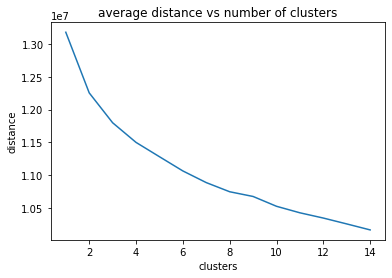

In [147]:
'''input: number of clusters you want to try at most (start at 2)'''
kmeans(15)

In [148]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_10=KMeans(n_clusters=10).fit(pca_copydf)
predictions=kmeans_10.predict(pca_copydf)

In [149]:
predictions

array([8, 2, 6, ..., 2, 1, 4])

In [150]:
##whats the difference between abs(kmeans.score(x)) and kmeans.tramsform(x)

In [151]:
#scoretest=KMeans().fit(pca_copydf_sub)
#abs(scoretest.score(pca_copydf_sub))

In [152]:
#transformtest=KMeans().fit(pca_copydf_sub)
#transformtest.transform(pca_copydf_sub)

In [153]:
#abs(transformtest.transform(pca_copydf_sub)).sum()

### Discussion 3.1: Apply Clustering to General Population

Elbow method shows the average distance between samples and centroid dropped gradually with number of clusters increased. Although there is a relative 'elbow' around cluster 2, it is still not very obvious. Due to the fact, I decided to take 10 clusters as the threshold so it can capture majority cohorts and not overfit.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [154]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [155]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean=clean_data(customers)

~~~~~~~~~~~~~~~ (191652, 79)


In [156]:
customers_clean.shape

(191652, 189)

In [166]:
# imput nan
customers_imput=imp.transform(customers_clean)
# StandardScaler with parameters
customers_scal=scaler_impute.transform(customers_imput)
# PCA 92 features
customers_pca=pca92.transform(customers_scal)
# KMeans clusters with 10 clusters
customers_pre=kmeans_10.predict(customers_pca)
customers_pre

array([5, 6, 9, ..., 5, 9, 6])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [158]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [159]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [160]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.